# Feature importance

Random Forest and Boosted Decision Trees both are based on Decision Trees to make predictions. However, Random Forest uses **Bagging**, which relies on training learners in parallel on different samples of the data and then combining by voting (discrete output) or by averaging (continuous output). It is really easy to implement and to parallelize (and therefore one of the most popular classifier for dense data). Whereas Boosted Decision Trees uses **Boosting**, which relies on training learner again, but after filtering/weighting samples based on output of previous train/test runs. In contrast to Random Forest, here the trees are trained independently as they are trained sequentially by boosting (meaning that each tree is trained to predict error residuals of previous trees). This technique allows to reduce the bias.

Our interest in Boosted Decision Trees lies in its potential ability to better tackle class imbalanced class distribution, prompting further investigation in this domain. This method seems the most comparable as it is a decision tree construction, to the RF that Muchlinski originally proposed. 

## 1) Kind of Boosted Decision Trees?

`sklearn` offers such a Boosting Decision Trees classifier: `AdaBoostClassifer`. 

Here is a bit of knowledge about AdaBoost : "The core principle of AdaBoost is to **fit a sequence of weak learners** (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a **weighted majority vote** (or sum) to produce the final prediction. The data modifications at each so-called **boosting iteration consist of applying weights $w_i$ to each of the training samples**. Initially, those weights are all set to $w_i = 1/N$ so that the first step simply trains a weak learner on the original data. For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. At a given step, **those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly**. As iterations proceed, **examples that are difficult to predict receive ever-increasing influence**. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence"

With this, we understand here why this kind of Boosted Decision Trees has potential to better handle imbalanced data. Civil War Onsets being extremely rare and hard to predict events, they will receive an ever-increasing importance attribution through the weights until it balances out the fact that they are rare in the dataset. This is why, we can hope that the model will be better suited (than RF) to predict these kind of events as it will be forced to concentrate on these hard to detected (because rare) events missed by the previous trees.

## Importing Libraries

In [1]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.ensemble import BalancedRandomForestClassifier # pip install imblearn - scikit wrapper

from helpers import load_data, roc_plt, get_params, save_pkl, load_pkl

##load the data 
DATA_PATH = '../data/'
PICKLE_PATH = '../pickles/'
IMG_PATH = '../imgs/'
seed = 7

master_data = load_data(DATA_PATH)

### Hyperparameter selection 

Hyperparameter selection was performed via grid search in cross validation, in notebook `ROC_no_feature_selection`, and selected according to the hyperparameters which yielded the highest auc score. We proceed with these best hyperparameters to determine variable importance for both the Random Forest, and the Boosted Decision Tree. 

In [2]:
params_brf = get_params("brf", PICKLE_PATH)
params_bdt = get_params("bdt", PICKLE_PATH)

params_bdt['base_estimator__max_depth'] = 4

BRF = BalancedRandomForestClassifier(random_state = 0)
BDT = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(), random_state = 0)

BRF.set_params(**params_brf)
BDT.set_params(**params_bdt)

print(BDT.get_params)

STD = StandardScaler()

<bound method BaseEstimator.get_params of AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),
                   n_estimators=140, random_state=0)>


In [3]:
def compute_FI(X, y, model, n_seeds):
    out_list = []
    
    # averaged over many seeds to get more consistent results
    for i in range(n_seeds):
        model.set_params(random_state = i)
        model.fit(X, y)
        out_list.append(model.feature_importances_)
    
    return out_list

In [4]:
X, y = master_data['muchlinski']
X[X.columns] = STD.fit_transform(X)

FI_BRF = compute_FI(X, y, BRF, 30)
FI_BDT = compute_FI(X, y, BDT, 30)

/home/loic/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/tree/_classes.py:590: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()
/home/loic/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/tree/_classes.py:590: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()
/home/loic/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/tree/_classes.py:590: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()
/home/loic/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/tree/_classes.py:590: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()
/home/loic/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/tree/_classes.py:590: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()
/home/loic/anaconda3/envs

In [5]:
def FI_plot(FI_list, X, title, top_n = 60, out_file=None, create_plot=False):
    # define mapping for columns
    FI_map = {v:k for k,v in enumerate(X.columns.values)}

    # retrieve mean 
    FI_stats = pd.DataFrame(FI_list).describe().T
    
    # construct dataframe
    FI_stats['Parameter'] = FI_map
    FI_stats = FI_stats.set_index('Parameter')
    FI_stats = FI_stats.sort_values("mean", ascending = True)
    
    # remove NaN / infinity values - not sure why these happen!
    FI_stats = FI_stats.replace([np.inf], np.nan)
    FI_stats = FI_stats.loc[FI_stats['mean'].notna()]
    
    # top_n
    FI_stats = FI_stats.head(top_n)
    
    # plot!
    l1 = FI_stats["mean"].values
    l2 = list(FI_stats.index.values)
    l3 = FI_stats["std"].values
    
    plt.figure(figsize = (10,20))
    plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

    plt.yticks(range(len(l2)),l2);
    plt.xlabel("Mean Importance According to Gini Decreases Normalized by Total Importance")
    plt.title(title)
    
    if out_file!=None: plt.savefig(out_file)
    plt.show() if create_plot else plt.close()

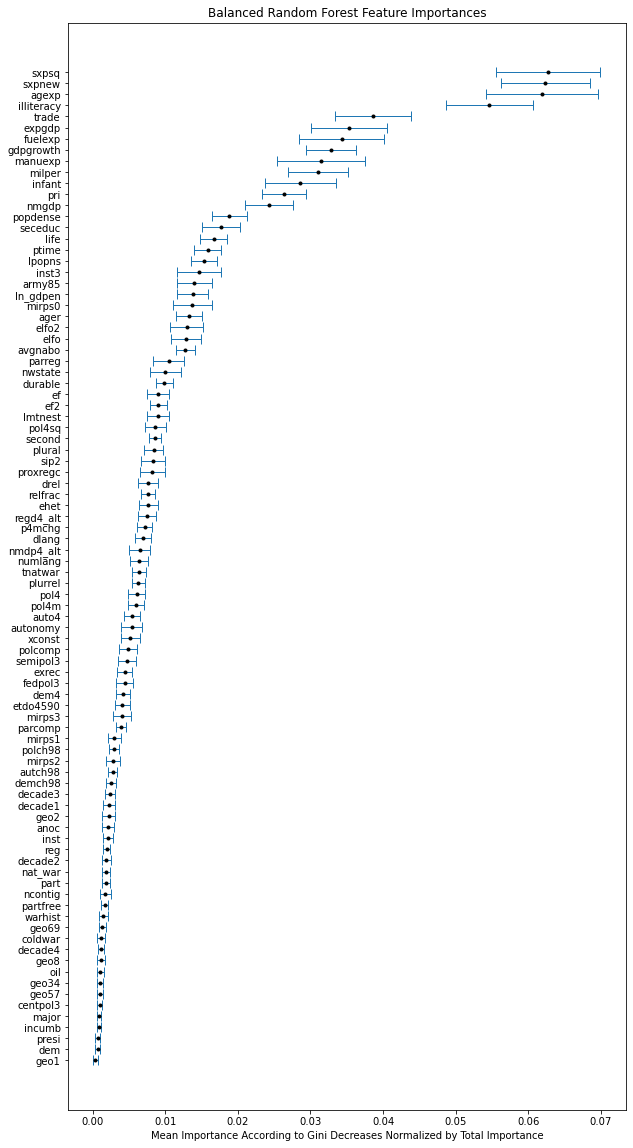

In [6]:
# create both pdf and png in case one is not hostable on blog
FI_plot(FI_BRF, X, 'Balanced Random Forest Feature Importances', X.shape[-1], IMG_PATH+'BRF_FI.pdf', create_plot=True)
FI_plot(FI_BRF, X, 'Balanced Random Forest Feature Importances', X.shape[-1], IMG_PATH+'BRF_FI.png')

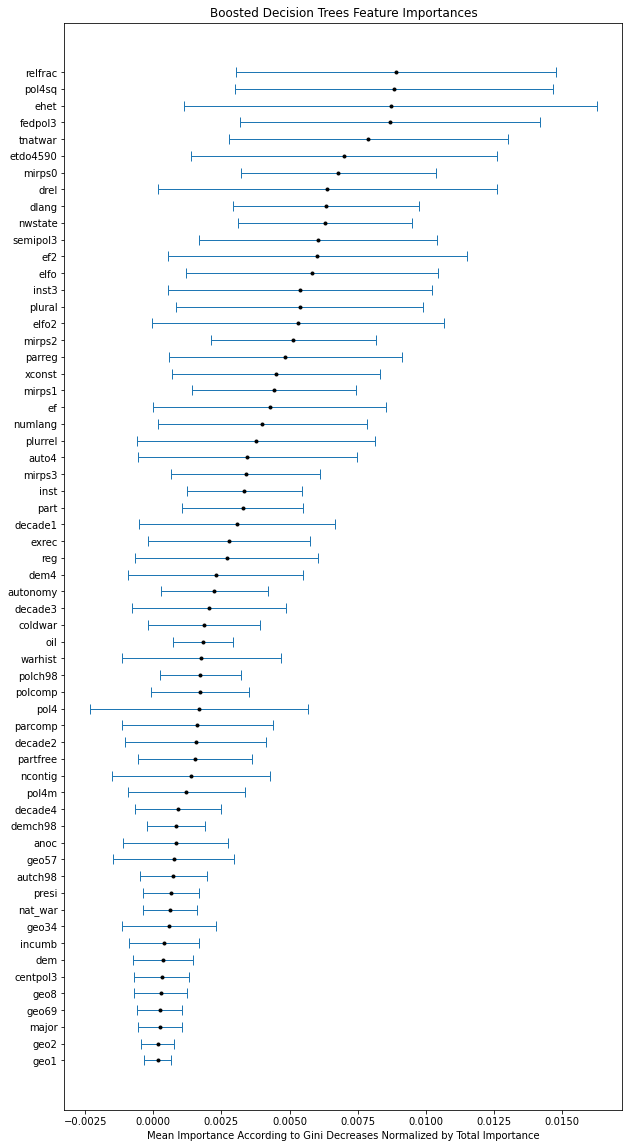

In [10]:
FI_plot(FI_BDT, X, 'Boosted Decision Trees Feature Importances', 60, IMG_PATH+'BDT_FI.pdf', create_plot=True)
FI_plot(FI_BDT, X, 'Boosted Decision Trees Feature Importances', 60, IMG_PATH+'BDT_FI.png')